In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Integrace pohybových rovnic

#### Lineární harmonický oscilátor

Vypočtěte trajektorii lineárního harmonického oscilátoru, kde síla je
$$F = -kx$$
a použijte následující parametry:

In [3]:
k = 1.
tmax = 20
dt = 0.1
v0 = 0
x0 = 1
m = 1

In [4]:
# Síla a potenciál LHO
def F(x, v, t, k=1):
    return -k*x
def U(x, v, t, k=1):
    return 0.5*k*x**2

 - Vykreslete výsledek do fázového diagramu $x$-$v$
 - Ověřte zákon zachování energie
 
 - Ten samý výpočet Euler Cromerovou metodou a porovnejte

Definujeme funkce pro Eulerovu a Eulerovu-Cromerovu metodu (trochu obecněji než je nutné, pro výpočty v 1D, 2D,...)

In [5]:
def euler_motion(F, m, x0, v0, tmax, dt):
    nstep = int(np.ceil(tmax/dt))
    x = np.zeros((nstep+1, len(x0)))
    v = np.zeros((nstep+1, len(x0)))
    t = np.arange(nstep+1)*dt
    
    x[0] = x0
    v[0] = v0
    
    for i in range(nstep):
        v[i+1] = v[i] + F(x[i], v[i], i*dt)/m * dt
        x[i+1] = x[i] + v[i] * dt
        
    return v, x, t

In [6]:
def euler_cromer_motion(F, m, x0, v0, tmax, dt):
    nstep = int(np.ceil(tmax/dt))
    x = np.zeros((nstep+1, len(x0)))
    v = np.zeros((nstep+1, len(x0)))
    t = np.arange(nstep+1)*dt
    
    x[0] = x0
    v[0] = v0
    
    for i in range(nstep):
        v[i+1] = v[i] + F(x[i], v[i], i*dt)/m * dt
        x[i+1] = x[i] + v[i+1] * dt
        
    return v, x, t

In [7]:
v_e, x_e, t_e = euler_motion(F, m, [x0], [v0], tmax, dt)
v_ec, x_ec, t_ec = euler_cromer_motion(F, m, [x0], [v0], tmax, dt)

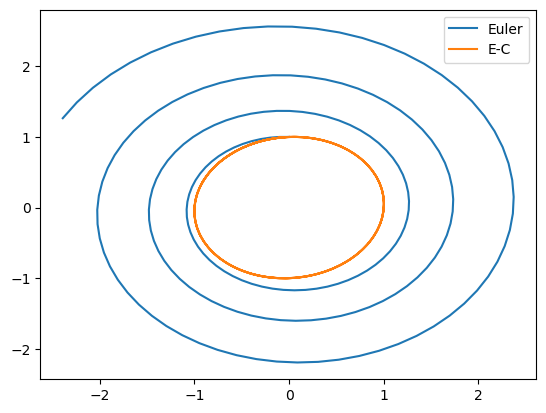

In [8]:
plt.plot(v_e, x_e, label="Euler")
plt.plot(v_ec, x_ec, label="E-C")
plt.legend()

In [9]:
def U(x, v, t, k=1):
    return 0.5*k*x**2
def E(x, v, t, m, k=1):
    return U(x, v, t, k) + 0.5*m*v**2
def E_lf(x, v, t, m, k=1):
    vi = (v[:-1] + v[1:])/2
    return U(x[:-1], vi, t, k) + 0.5*m*vi**2

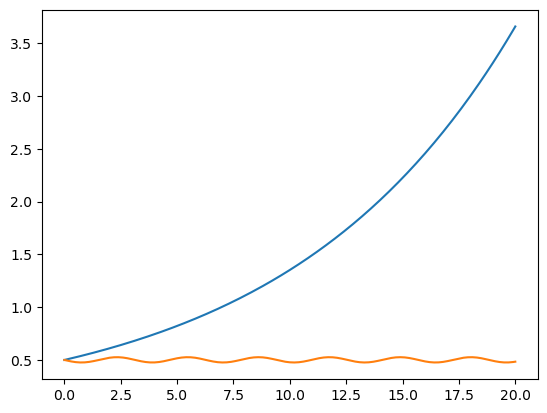

In [10]:
plt.plot(t_e, E(x_e, v_e, 0, 1, 1), label="Euler")
plt.plot(t_ec, E(x_ec, v_ec, 0, 1, 1), label="E-C")


Vidíme, že Eulerova nezachovává energie na rozdíl od Eulerovy Cromerovy

### Porovnejte s metodami vyššího řádu
Verlet nebo Leap-Frog a pro srovnání Rungova-Kuttova (RK45 ze scipy) 

In [11]:
def verlet_motion(F, m, x0, v0, tmax, dt):
    nstep = int(np.ceil(tmax/dt))
    x = np.zeros((nstep+1, *np.shape(x0)))
    v = np.zeros((nstep+1, *np.shape(x0)))
    t = np.arange(nstep+1)*dt

    x[0] = x0
    v[0] = v0
    
    a_old = F(x[0], v[0], 0)/m
    for i in range(nstep):
        x[i+1] = x[i] + v[i] * dt + 0.5*a_old * dt**2
        a_new = F(x[i+1], v[i], (i+1)*dt)/m
        v[i+1] = v[i] +  0.5*(a_new + a_old) * dt
        a_old = a_new
        
    return v, x, t

In [19]:
def verlet_motion2(F, m, x0, v0, tmax, dt):
    nstep = int(np.ceil(tmax/dt))
    x = np.zeros((nstep+1, *np.shape(x0)))
    v = np.zeros((nstep+1, *np.shape(x0)))
    t = np.arange(nstep+1)*dt

    x[0] = x0
    v[0] = v0
    
    a = F(x[0], v[0], 0)/m
    for i in range(nstep):
        v_half = v[i] + 0.5 * a * dt
        x[i+1] = x[i] + v_half * dt
        a = F(x[i+1], v[i], (i+1)*dt)/m
        v[i+1] = v_half +  0.5 * a * dt
        
    return v, x, t

In [20]:
def leap_frog_motion(F, m, x0, v0, tmax, dt):
    nstep = int(np.ceil(tmax/dt))
    x = np.zeros((nstep+1, len(x0)))
    v = np.zeros((nstep+1, len(x0)))
    t = np.arange(nstep+1)*dt
    
    x[0] = x0
    v[0] = v0
    
    # leapfrog init, v[i] = v((i-0.5)*dt)
    v[0] = v[0] - F(x[0], v[0], 0)/m * 0.5*dt
    
    for i in range(nstep):
        v[i+1] = v[i] + F(x[i], v[i], i*dt)/m * dt
        x[i+1] = x[i] + v[i+1] * dt
        
    return v, x, t

In [21]:
from scipy.integrate import solve_ivp
def scipy_motion(F, m, x0, v0, tmax, dt):
    dim = len(x0)
    
    def rhs(t, y): 
        x, v = y[:dim], y[dim:]
        dxdt = v
        dvdt = F(x, v, t)/m
        return np.hstack((dxdt, dvdt))
    
    y0 = np.hstack((x0, v0))
    
    sol = solve_ivp(rhs, [0, tmax], y0)
    
    x = sol.y[:dim].T
    v = sol.y[dim:].T
        
    return v, x, sol.t

In [22]:
#v_e, x_e, t_e = euler_motion(F, 1, [1], [0], 20, 0.1)
#v_ec, x_ec, t_ec = euler_cromer_motion(F, 1, [1], [0], 20, 0.1)
v_lf, x_lf, t_lf = leap_frog_motion(F, m, [x0], [v0], tmax, dt)
v_v, x_v, t_v = verlet_motion2(F, m, [x0], [v0], tmax, dt)
v_s, x_s, t_s = scipy_motion(F, m, [x0], [v0], tmax, dt)

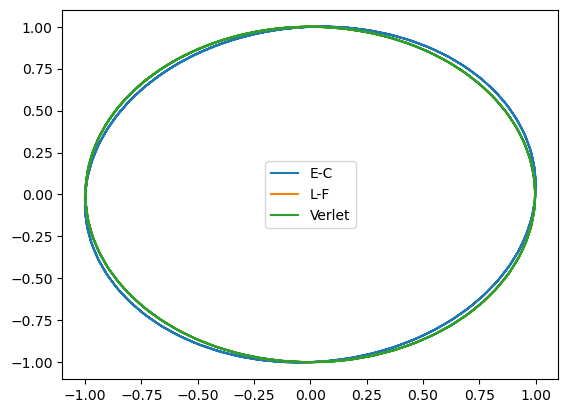

In [23]:
plt.plot(v_ec, x_ec, label="E-C")
plt.plot((v_lf[:-1]+v_lf[1:])/2, x_lf[:-1], label="L-F")
plt.plot(v_v, x_v, label="Verlet")
plt.legend()

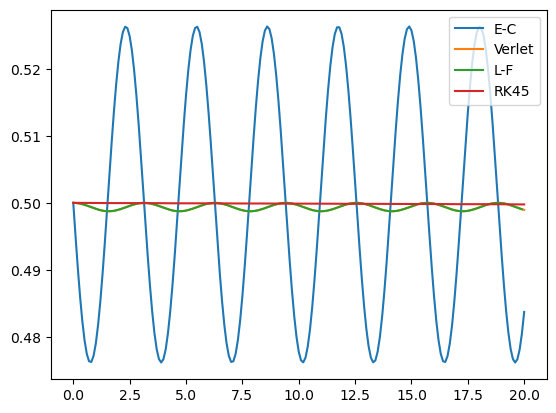

In [24]:
plt.plot(t_ec, E(x_ec, v_ec, 0, m, k), label="E-C")
plt.plot(t_v, E(x_v, v_v, 0, m, k), label="Verlet")
plt.plot(t_lf[:-1], E_lf(x_lf, v_lf, 0, m, k), label="L-F")
plt.plot(t_s, E(x_s, v_s, 0, m, k), label="RK45")
plt.legend()

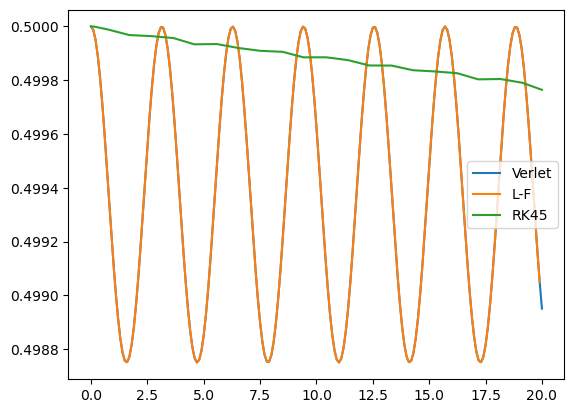

In [25]:
plt.plot(t_v, E(x_v, v_v, 0, m, k), label="Verlet")
plt.plot(t_lf[:-1], E_lf(x_lf, v_lf, 0, m, k), label="L-F")
plt.plot(t_s, E(x_s, v_s, 0, m, k), label="RK45")
plt.legend()

Porovnání časové náročnosti

In [26]:
%%timeit 
v_lf, x_lf, t_lf = leap_frog_motion(F, 1, [1], [0], 20, 0.1)

692 µs ± 4.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%%timeit
v_s, x_s, t_s = scipy_motion(F, 1, [1], [0], 20, 0.1)

928 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Pohyb v polarizačním potenciálu 
$U\sim -1/r^4$ - srážka iontu s neutrální molekulou

In [31]:
def F(x, v, t, k=1):
    r = np.sqrt(np.sum(x**2))
    return -4*k*(x/r)/r**5
def U(x, v, t, k=1):
    r = np.sqrt(np.sum(x**2))
    return -k/r**4
def E(x, v, t, m, k=1):
    return U(x, v, t, k) + 0.5*m*v**2

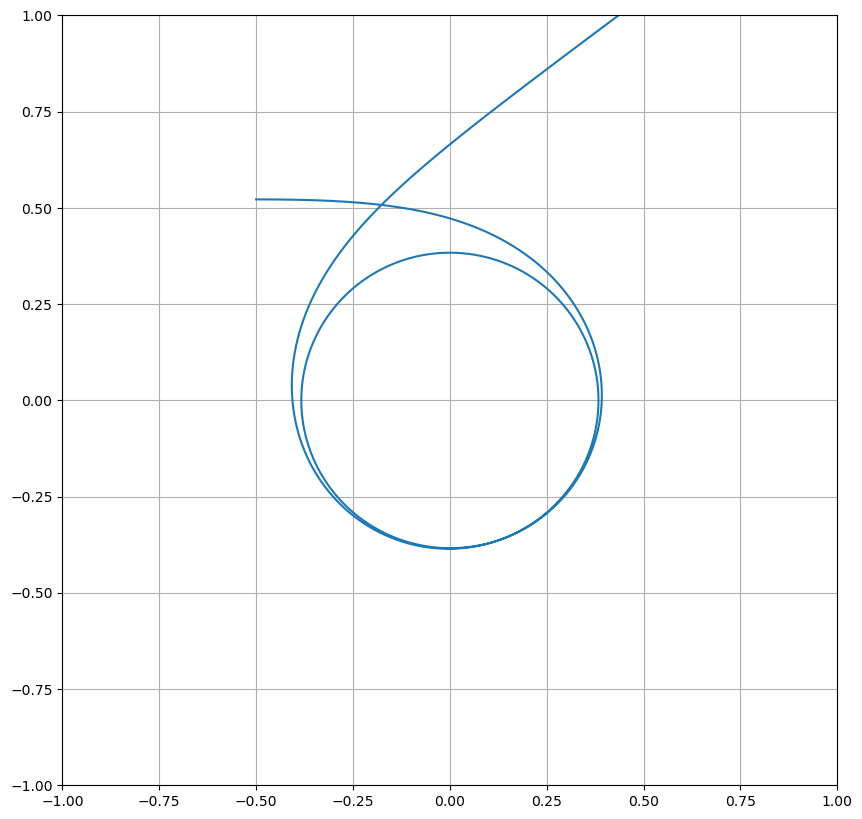

In [38]:
plt.figure(figsize=(10, 10))
xi = 0.52180499
v0 = np.array([10, 0])
x0 = np.array([-.5, xi])
tmax = 0.5
dt = 0.00002
v_e, x_e, t_e = euler_motion(F, 1, x0, v0, tmax, dt)
v_ec, x_ec, t_ec = euler_cromer_motion(F, 1, x0, v0, tmax, dt)

rmin = 0.03
r = np.sqrt(np.sum(x_ec**2, axis=1))
last = np.where(r<rmin)[0]
if len(last)==0:
    last = None
else:
    last = last[0]

plt.plot(x_ec[:last,0], x_ec[:last,1], "-")
#plt.plot(x_e[:last,0], x_e[:last,1], "-")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()

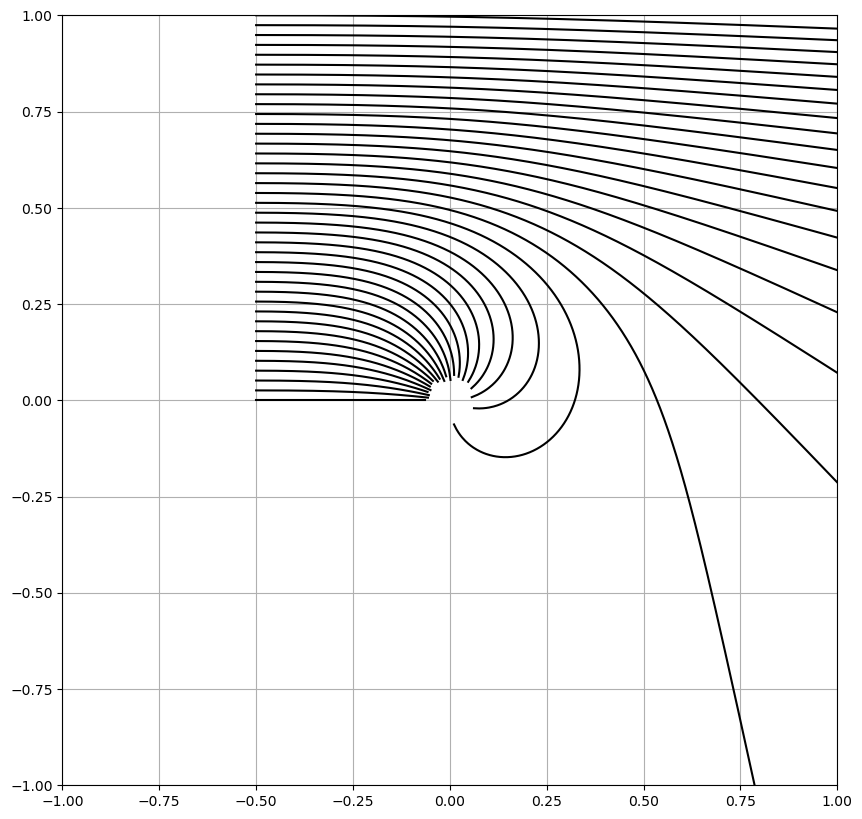

In [30]:
plt.figure(figsize=(10, 10))
for xi in np.linspace(0, 1, 40):
    v0 = np.array([10, 0])
    x0 = np.array([-.5, xi])
    tmax = 0.5
    dt = 0.00005
    #v_e, x_e, t_e = euler_motion(F, 1, x0, v0, tmax, dt)
    v_ec, x_ec, t_ec = euler_cromer_motion(F, 1, x0, v0, tmax, dt)
    r = np.sqrt(np.sum(x_ec**2, axis=1))
    last = np.where(r<0.05)[0]
    if len(last)==0:
        last = None
    else:
        last = last[0]
    plt.plot(x_ec[:last,0], x_ec[:last,1], "-k")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()